# Model Reliability & Failure Detection

This project focuses on **understanding when a machine learning model should NOT be trusted**.

Instead of assuming every prediction is correct, the goal is to analyze model behavior and identify cases where predictions are likely to fail. A second ML model is trained to estimate **prediction reliability**, helping prevent silent errors in real-world systems.


In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification


In [2]:
# generate a binary classification dataset
X, y = make_classification(
    n_samples=3000,
    n_features=12,
    n_informative=6,
    n_redundant=2,
    n_classes=2,
    flip_y=0.08,
    random_state=42
)

df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df['target'] = y

df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target
0,0.482592,1.826714,0.247443,1.327555,-2.965211,2.963840,-1.602666,0.635566,-3.735394,0.141777,0.030519,-0.156945,0
1,-1.445746,0.764400,0.374991,-0.347805,1.087411,-0.916399,-0.514635,1.867414,1.136605,0.039280,0.811162,1.133847,1
2,1.256750,-1.500443,0.976345,0.687767,-0.874965,0.536780,2.276771,-1.116950,-0.137907,-0.429464,0.614080,2.111058,0
3,-0.540782,-1.537844,2.300008,-0.360108,0.725097,-2.114513,-2.386024,0.760883,0.885007,-1.285555,2.389347,-0.769846,1
4,-0.168223,0.199177,1.917083,1.471366,-0.725075,-0.103180,-1.184691,1.815242,-1.143996,-0.843326,1.215072,-0.225199,1


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

base_model = LogisticRegression(max_iter=1000)
base_model.fit(X_train, y_train)

base_preds = base_model.predict(X_test)
accuracy_score(y_test, base_preds)


0.8813333333333333

In [5]:
# check which predictions were wrong
prediction_correct = (base_preds == y_test.values).astype(int)

prediction_correct[:10]


array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [6]:
# get prediction confidence
confidence = np.max(base_model.predict_proba(X_test), axis=1)

reliability_df = X_test.copy()
reliability_df['confidence'] = confidence
reliability_df['model_correct'] = prediction_correct

reliability_df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,confidence,model_correct
785,-1.466484,1.462627,-0.376218,-1.882695,0.279408,0.048772,0.627848,1.768779,0.763304,0.416592,0.045175,-1.062335,0.722317,1
2182,0.507699,0.535855,2.175038,-1.017315,-0.270417,-0.586226,-1.967024,2.764989,-1.526360,-0.107485,0.895098,-0.535993,0.867337,0
2289,-0.853766,3.184496,-1.115100,-0.655751,0.937225,1.822713,1.836871,2.520182,-2.132997,-0.995997,-2.879569,1.683415,0.960161,1
2532,-1.277600,-0.090016,1.758091,0.902492,0.888839,0.312526,-1.533989,0.421507,-3.949538,0.387827,-1.853894,0.952591,0.981645,0
2146,-0.364935,-0.757617,-0.666012,-0.127501,-0.376589,0.215394,-0.939220,-2.193265,-0.989390,-1.253766,-1.236750,-1.032676,0.976149,1


In [7]:
X_rel = reliability_df.drop('model_correct', axis=1)
y_rel = reliability_df['model_correct']

X_rel_train, X_rel_test, y_rel_train, y_rel_test = train_test_split(
    X_rel, y_rel, test_size=0.25, random_state=42, stratify=y_rel
)


In [8]:
reliability_model = LogisticRegression(max_iter=1000)
reliability_model.fit(X_rel_train, y_rel_train)

rel_preds = reliability_model.predict(X_rel_test)
accuracy_score(y_rel_test, rel_preds)


0.8882978723404256

In [9]:
final_view = pd.DataFrame({
    'base_prediction': base_model.predict(X_rel_test.drop('confidence', axis=1)),
    'base_confidence': X_rel_test['confidence'].values,
    'prediction_reliable': rel_preds
})

final_view.head()


,base_prediction,base_confidence,prediction_reliable
0,1,0.798146,1
1,1,0.937621,1
2,0,0.998063,1
3,1,0.802097,1
4,0,0.993073,1


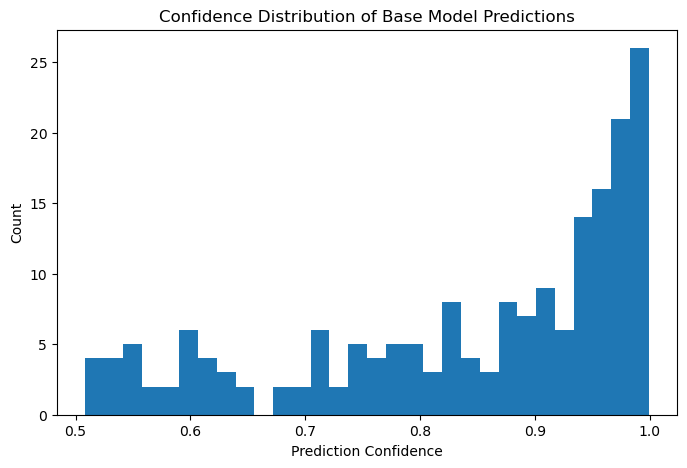

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(final_view['base_confidence'], bins=30)
plt.xlabel("Prediction Confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution of Base Model Predictions")
plt.show()
